In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re
import numpy as np
import seaborn as sns
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit 
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture


In [23]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


In [2]:
### read in the transformed image data
file = "/home/smmrrr/Fog_Imaging_Project/images_flattened.csv"
flattened = np.genfromtxt(file, delimiter=',', skip_header=0, dtype=float, names=None)

In [3]:
flattened.shape

(68972, 3072)

In [4]:
## read in labels 
photo_links = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/all_photos_link.csv')
photo_labels = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Holman_Labels_Attempt1.csv')
# photo_links
photo_labels.loc[0,'Url']
photo_labels['link'] = photo_labels['Url'].apply(lambda x: re.sub(r'AmlDatastore://workspaceblobstore/UI/2023-04-01_002812_UTC/label_image_data2/'
                                                  ,'',x))
# photo_links
links_and_labels = photo_links.merge(photo_labels, how = 'left', right_on = 'link', left_on = 'project_files_location')
links_and_labels['Label'] = links_and_labels['Label'].fillna('Not_Labeled')
image_files_summary = links_and_labels['project_files_location'].str.split(r'[\.|\_]',expand = True)
image_files_summary.columns = ['number_id', 'weekday', 'month_abv', 'day', 'hour', 'min', 'second', 'tz', 'year', 'camera', 'camera_angle', 'image_capture_type', 'ext']
# image_files_summary['filename'] = image_files

links_and_labels = pd.concat([links_and_labels, image_files_summary], axis = 1 )
links_and_labels['year'] = links_and_labels['year'].astype(int)
links_and_labels['day']=links_and_labels['day'].astype(int)
links_and_labels['hour']=links_and_labels['hour'].astype(int)
# links_and_labels['month']=links_and_labels.apply(lambda row: datetime.strptime(row['month_abv'], '%b').month)
# links_and_labels['month']=datetime.strptime(links_and_labels['month_abv'], '%b').month
links_and_labels['month']=links_and_labels['month_abv'].apply(lambda x: datetime.strptime(x, '%b').month)
links_and_labels['time'] = links_and_labels.apply(lambda row: datetime(row['year'], row['month'], row['day'], row['hour']), axis=1)



In [5]:

# Specify the original timezone (if different from system timezone)
original_timezone = pytz.timezone('GMT')

# Convert to Pacific Time
pacific_timezone = pytz.timezone('US/Pacific')
links_and_labels['time_pst'] = links_and_labels['time'].dt.tz_localize(original_timezone).dt.tz_convert(pacific_timezone)



In [6]:
links_and_labels

,project_files_location,photo_size,Url,Label,LabelConfidence,link,number_id,weekday,month_abv,day,...,second,tz,year,camera,camera_angle,image_capture_type,ext,month,time,time_pst
0,746574512.Sat.Aug.28_21_48_32.GMT.1993.argus00...,"(480, 640)",NaN,Not_Labeled,NaN,NaN,746574512,Sat,Aug,28,...,32,GMT,1993,argus00,c0,snap,jpg,8,1993-08-28 21:00:00,1993-08-28 14:00:00-07:00
1,905736605.Mon.Sep.14_01_30_05.GMT.1998.argus00...,"(480, 640, 3)",NaN,Not_Labeled,NaN,NaN,905736605,Mon,Sep,14,...,05,GMT,1998,argus00,c0,snap,jpg,9,1998-09-14 01:00:00,1998-09-13 18:00:00-07:00
2,1151780400.Sat.Jul.01_19_00_00.GMT.2006.argus0...,"(960, 1280, 3)",NaN,Not_Labeled,NaN,NaN,1151780400,Sat,Jul,1,...,00,GMT,2006,argus00,c0,snap,jpg,7,2006-07-01 19:00:00,2006-07-01 12:00:00-07:00
3,995580007.Thu.Jul.19_22_00_07.GMT.2001.argus00...,"(480, 640, 3)",NaN,Not_Labeled,NaN,NaN,995580007,Thu,Jul,19,...,07,GMT,2001,argus00,c0,snap,jpg,7,2001-07-19 22:00:00,2001-07-19 15:00:00-07:00
4,1560808800.Mon.Jun.17_22_00_00.GMT.2019.argus0...,"(960, 1280, 3)",NaN,Not_Labeled,NaN,NaN,1560808800,Mon,Jun,17,...,00,GMT,2019,argus00,c0,snap,jpg,6,2019-06-17 22:00:00,2019-06-17 15:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68967,802803635.Sat.Jun.10_17_00_35.GMT.1995.argus00...,"(480, 640)",NaN,Not_Labeled,NaN,NaN,802803635,Sat,Jun,10,...,35,GMT,1995,argus00,c0,snap,jpg,6,1995-06-10 17:00:00,1995-06-10 10:00:00-07:00
68968,1408485600.Tue.Aug.19_22_00_00.GMT.2014.argus0...,"(960, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Foggy,1.0,1408485600.Tue.Aug.19_22_00_00.GMT.2014.argus0...,1408485600,Tue,Aug,19,...,00,GMT,2014,argus00,c0,snap,jpg,8,2014-08-19 22:00:00,2014-08-19 15:00:00-07:00
68969,842547625.Thu.Sep.12_17_00_25.GMT.1996.argus00...,"(480, 640)",NaN,Not_Labeled,NaN,NaN,842547625,Thu,Sep,12,...,25,GMT,1996,argus00,c0,snap,jpg,9,1996-09-12 17:00:00,1996-09-12 10:00:00-07:00
68970,966366006.Tue.Aug.15_19_00_06.GMT.2000.argus00...,"(480, 640, 3)",NaN,Not_Labeled,NaN,NaN,966366006,Tue,Aug,15,...,06,GMT,2000,argus00,c0,snap,jpg,8,2000-08-15 19:00:00,2000-08-15 12:00:00-07:00


In [7]:
links_and_labels=links_and_labels[links_and_labels['time_pst'].dt.hour.between(7, 20)]
links_and_labels=links_and_labels.loc[links_and_labels['Label'].isin(['Not_Foggy', 'Foggy'])]

In [8]:
flattened = flattened[links_and_labels.index,:]
flattened.shape

(3002, 3072)

In [9]:
links_and_labels = links_and_labels.reset_index()

In [10]:
#### "cloud sensitive image metrics"

##calculating luminescence 

##coefficient of variation (sigma over mu)
cv = flattened.std(axis = 1) / flattened.mean(axis = 1)
print(len(cv))

##michelsons contrast 
mc = (flattened.max(axis = 1)-flattened.min(axis = 1)) / (flattened.max(axis = 1)+flattened.min(axis = 1))
print(len(mc))

##
# H = stats.entropy(axis = 1)

3002
3002


In [11]:
kde_results = np.apply_along_axis(gaussian_kde, 1, flattened)
# len(kde_results)
# # Generate points to evaluate the KDE
x = np.linspace(np.min(flattened), np.max(flattened), 100)
H = [stats.entropy(kde.pdf(x)) for kde in kde_results]
print(len(H))
# # Calculate the normalized probabilities for each row
# probabilities = pdf_values / np.sum(pdf_values, axis=1)[:, np.newaxis]



3002


In [17]:
links_and_labels.loc[image_data.loc[image_data['mc']==1].index,: ]

,index,project_files_location,photo_size,Url,Label,LabelConfidence,link,number_id,weekday,month_abv,...,second,tz,year,camera,camera_angle,image_capture_type,ext,month,time,time_pst
0,12,1027692007.Fri.Jul.26_14_00_07.GMT.2002.argus0...,"(480, 640, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Foggy,1.0,1027692007.Fri.Jul.26_14_00_07.GMT.2002.argus0...,1027692007,Fri,Jul,...,07,GMT,2002,argus00,c0,snap,jpg,7,2002-07-26 14:00:00,2002-07-26 07:00:00-07:00
2,65,899609405.Sun.Jul.05_03_30_05.GMT.1998.argus00...,"(480, 640, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,899609405.Sun.Jul.05_03_30_05.GMT.1998.argus00...,899609405,Sun,Jul,...,05,GMT,1998,argus00,c0,snap,jpg,7,1998-07-05 03:00:00,1998-07-04 20:00:00-07:00
5,126,771208930.Fri.Jun.10_00_42_10.GMT.1994.argus00...,"(480, 640)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,771208930.Fri.Jun.10_00_42_10.GMT.1994.argus00...,771208930,Fri,Jun,...,10,GMT,1994,argus00,c0,snap,jpg,6,1994-06-10 00:00:00,1994-06-09 17:00:00-07:00
6,136,993481207.Mon.Jun.25_15_00_07.GMT.2001.argus00...,"(480, 640, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,993481207.Mon.Jun.25_15_00_07.GMT.2001.argus00...,993481207,Mon,Jun,...,07,GMT,2001,argus00,c0,snap,jpg,6,2001-06-25 15:00:00,2001-06-25 08:00:00-07:00
7,137,809481620.Sun.Aug.27_00_00_20.GMT.1995.argus00...,"(480, 640)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,809481620.Sun.Aug.27_00_00_20.GMT.1995.argus00...,809481620,Sun,Aug,...,20,GMT,1995,argus00,c0,snap,jpg,8,1995-08-27 00:00:00,1995-08-26 17:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,68613,895188605.Thu.May.14_23_30_05.GMT.1998.argus00...,"(480, 640, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,895188605.Thu.May.14_23_30_05.GMT.1998.argus00...,895188605,Thu,May,...,05,GMT,1998,argus00,c0,snap,jpg,5,1998-05-14 23:00:00,1998-05-14 16:00:00-07:00
2988,68664,1095451206.Fri.Sep.17_20_00_06.GMT.2004.argus0...,"(480, 640, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,1095451206.Fri.Sep.17_20_00_06.GMT.2004.argus0...,1095451206,Fri,Sep,...,06,GMT,2004,argus00,c0,snap,jpg,9,2004-09-17 20:00:00,2004-09-17 13:00:00-07:00
2991,68809,746313180.Wed.Aug.25_21_13_00.GMT.1993.argus00...,"(480, 640)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,746313180.Wed.Aug.25_21_13_00.GMT.1993.argus00...,746313180,Wed,Aug,...,00,GMT,1993,argus00,c0,snap,jpg,8,1993-08-25 21:00:00,1993-08-25 14:00:00-07:00
2996,68855,1123799406.Thu.Aug.11_22_30_06.GMT.2005.argus0...,"(480, 640, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Not_Foggy,1.0,1123799406.Thu.Aug.11_22_30_06.GMT.2005.argus0...,1123799406,Thu,Aug,...,06,GMT,2005,argus00,c0,snap,jpg,8,2005-08-11 22:00:00,2005-08-11 15:00:00-07:00


In [20]:
flattened[0,:].min()

0.0

In [12]:
image_data = np.concatenate( (np.array(H).reshape(3002,1),mc.reshape(3002,1),cv.reshape(3002,1)), axis = 1)
image_data = pd.DataFrame(image_data, columns = ['H','mc', 'cv'])
image_data

,H,mc,cv
0,4.207546,1.000000,0.414847
1,4.489217,0.901403,0.731413
2,4.261625,1.000000,0.563232
3,4.336845,0.958314,0.858244
4,4.472931,0.999165,0.487978
...,...,...,...
2997,4.221743,1.000000,0.534441
2998,4.363413,0.907906,0.867870
2999,4.507301,0.999432,0.485958
3000,3.832859,0.857931,0.704622


In [15]:
labels = links_and_labels[['Label']].reset_index(drop=True)
plot_data = pd.concat([image_data, labels], axis = 1)
# plot_data.loc[plot_data['Label'].isna(), 'Label'] = 'un-labeled'
plot_data

,H,mc,cv,Label
0,4.207546,1.000000,0.414847,Foggy
1,4.489217,0.901403,0.731413,Not_Foggy
2,4.261625,1.000000,0.563232,Not_Foggy
3,4.336845,0.958314,0.858244,Not_Foggy
4,4.472931,0.999165,0.487978,Not_Foggy
...,...,...,...,...
2997,4.221743,1.000000,0.534441,Not_Foggy
2998,4.363413,0.907906,0.867870,Not_Foggy
2999,4.507301,0.999432,0.485958,Not_Foggy
3000,3.832859,0.857931,0.704622,Foggy


Text(0.5, 20.4, 'Shannon Entropy')

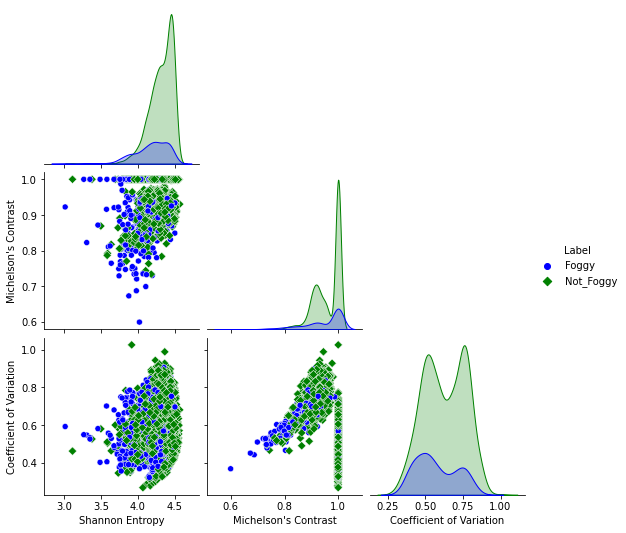

In [16]:
g = sns.pairplot(plot_data, hue = 'Label', palette={'Foggy': 'blue', 'Not_Foggy': 'green'}, markers=["o", "D"], corner=True)
g.axes[2, 0].set_ylabel('Coefficient of Variation')
g.axes[1, 0].set_ylabel('Michelson\'s Contrast')
g.axes[0, 0].set_ylabel('Shannon Entropy')

g.axes[2, 2].set_xlabel('Coefficient of Variation')
g.axes[2, 1].set_xlabel('Michelson\'s Contrast')
g.axes[2, 0].set_xlabel('Shannon Entropy')
# # g.set_axis_labels('Coefficient of Variation', 'Michelson\'s Contrast', 'Shannon Entropy')

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


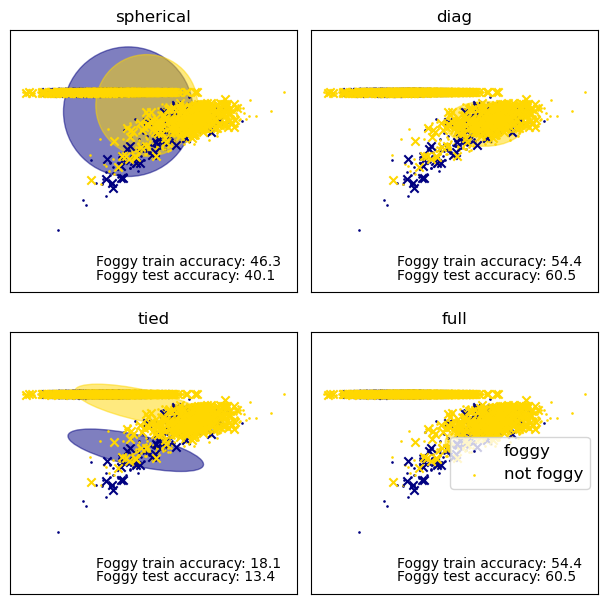

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "gold"]
names = ["foggy", "not foggy"]

X = np.concatenate((cv.reshape(3002,1), mc.reshape(3002,1), np.array(H).reshape(3002,1)), axis = 1)
y =  np.array([0 if x == "Foggy" else 1 for x in np.array(plot_data.Label)])
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=2)
# next(skf.split(X, y))
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

n_classes = len(np.unique(y_train))


# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]


# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    # train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    train_accuracy = np.mean(y_train_pred[np.where(y_train==0)] == 0)*100
    plt.text(0.3, 0.1, "Foggy train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    # test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    test_accuracy = np.mean(y_test_pred[np.where(y_test==0)] == 0)*100
    plt.text(0.3, 0.05, "Foggy test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    # plt.xlim(0.6, .7)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)
    # plt.ylim(y_min, y_max)
# plt.xlim(0, .5)

plt.legend(scatterpoints=1, loc="center right", prop=dict(size=12))


plt.show()


In [ ]:
labels = links_and_labels[['Label', 'site']].reset_index(drop=True)
plot_data = pd.concat([image_data, labels], axis = 1)
# plot_data.loc[plot_data['Label'].isna(), 'Label'] = 'un-labeled'
plot_data

In [27]:
labels = links_and_labels[['Label', 'project_files_location']]
plot_data = pd.concat([image_data, labels], axis = 1)
plot_data.loc[plot_data['Label'].isna(), 'Label'] = 'un-labeled'

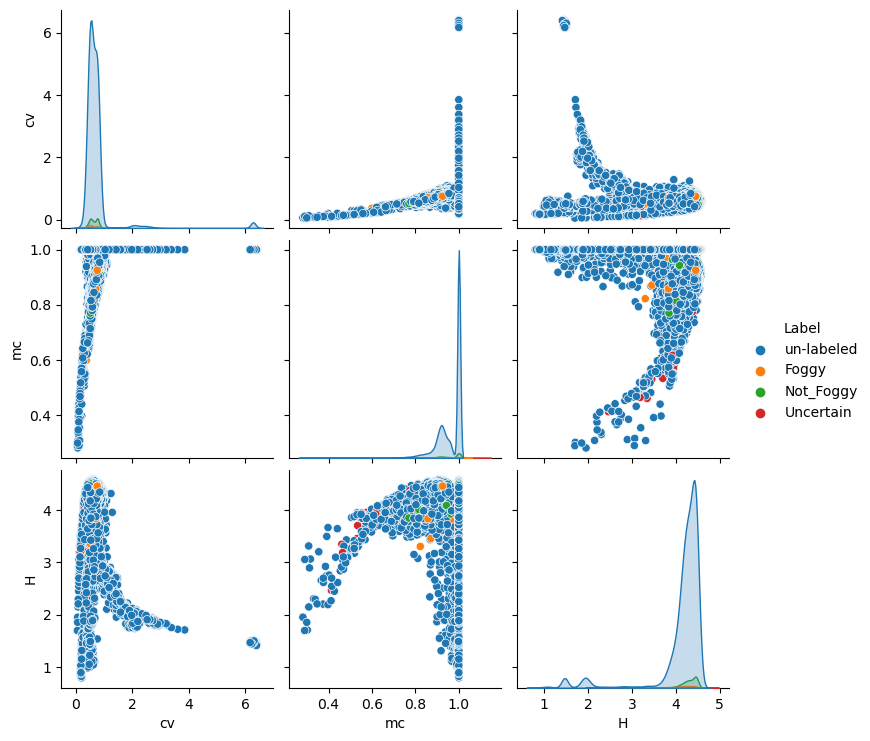

In [28]:
sns.pairplot(plot_data, hue = 'Label')